In [1]:
import os
import numpy as np 
import pandas as pd
from scipy import stats, signal, io
import mne
from mne import create_info, EpochsArray
from mne.time_frequency import tfr_morlet
from bids import BIDSLayout
import mne_bids
import scipy
#import settings
import json
#from coordinates_io import BIDS_coord
from sklearn import linear_model, metrics
import multiprocessing
from sklearn.model_selection import cross_val_score
from sklearn import ensemble, model_selection
from matplotlib import pyplot as plt
import matplotlib 
from multiprocessing import get_context
from multiprocessing import Process

In [18]:
BIDS_path = 'C:\\Users\\ICN_admin\\Documents\\BIDS\\'
subject_id = ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']
out_path = 'C:\\Users\\ICN_admin\\Documents\\ECOGVSTN\\Figure 2\\LM_100ms\\'

In [19]:
def read_BIDS_file(vhdr_file):
    """
    Read one run file from BIDS standard
    :param vhdr_file: 
    :return: raw dataset array, channel name array
    """
    bv_file = mne_bids.read.io.brainvision.read_raw_brainvision(vhdr_file)
    bv_raw = bv_file.get_data()
    return bv_raw, bv_file.ch_names

In [20]:
def get_all_files_of_type(BIDS_path, type_='.vhdr'):
    """
    
    Given a BIDS path return all vhdr file paths without BIDS_Layout
    Args:
        BIDS_path (string)
    Returns: 
        vhdr_files (list)
    """
    vhdr_files = []
    for root, dirs, files in os.walk(BIDS_path):
        for file in files:
            if file.endswith(type_):
                vhdr_files.append(os.path.join(root, file))
    return vhdr_files

In [21]:
vhdr_files = get_all_files_of_type(BIDS_path, '.vhdr')
tsv_files = get_all_files_of_type(BIDS_path, '.tsv')

In [22]:
# Plot mean of weights for best performing LMs

In [23]:
def get_best(dict_ch, Con=True, ECOG=True, get_weights=True, get_data=False, measure='R2'):
    """
    return best channel name, best channel performance, and respective weights
    """
    channels = list(dict_ch.keys())
    if ECOG is True:
        list_ch = [ch for ch in channels if 'ECOG' in ch]
        num_ch = len(list_ch)
    else:
        list_ch = [ch for ch in channels if 'STN' in ch]
        num_ch = len(list_ch)

    if num_ch == 0:
        raise ValueError

    
    acc_ = np.zeros(num_ch)
    mov_idx_ = np.zeros(num_ch)
    counter_ch = 0

    for ch_idx, ch  in enumerate(channels):
        if ECOG is True and 'STN' in ch:
            continue
        elif ECOG is False and 'ECOG' in ch:
            continue
        mov_channels = dict_ch[channels[ch_idx]]["mov_ch"]
        mov_idx = get_movement_idx(channels[ch_idx], mov_channels, Con)
        acc_[counter_ch] = dict_ch[channels[ch_idx]]['res_'+mov_channels[mov_idx]][measure]
        mov_idx_[counter_ch] = mov_idx
        counter_ch += 1

    best_ch_idx = np.argmax(acc_)
    mov_idx_best = int(mov_idx_[best_ch_idx])
    best_ch = list_ch[best_ch_idx]; best_acc = np.max(acc_)
    if get_weights is False:
        if get_data is False:
            return best_ch, best_acc
        else:
            return best_ch, best_acc, np.array(dict_ch[best_ch]['data']), \
                                       np.array(dict_ch[best_ch]['true_movements'])[mov_idx_best,:]
    best_weights = dict_ch[channels[best_ch_idx]]['res_'+mov_channels[mov_idx_best]]['weight_'+mov_channels[mov_idx_best]]
    return best_ch, best_acc, best_weights

In [24]:
def get_best_weights_single_time_point(out_path):
    weights_ecog_con = []; weights_ecog_ips = []
    weights_stn_con = []; weights_stn_ips = []

    for sub_idx, subject_id_ in enumerate(subject_id):

        with open(out_path+'sub_'+subject_id_+'_patient_concat.json', 'r') as fp:
            dict_ch = json.load(fp)

        weights_ecog_con.append(get_best(dict_ch, Con=True, ECOG=True)[2])
        weights_ecog_ips.append(get_best(dict_ch, Con=False, ECOG=True)[2])
        try:
            weights_stn_con.append(get_best(dict_ch, Con=True, ECOG=False)[2])
            weights_stn_ips.append(get_best(dict_ch, Con=False, ECOG=False)[2])
        except ValueError:  # no STN here
            pass
    return np.array(weights_ecog_con), np.array(weights_ecog_ips), np.array(weights_stn_con), np.array(weights_stn_ips)


In [29]:
def plot_single_time_point_weights(out_path):
    
    weights_ecog_con, weights_ecog_ips, weights_stn_con, weights_stn_ips = get_best_weights_single_time_point(out_path)
    
    plt.figure(figsize=(10, 4), dpi=300)
    plt.subplot(1,2,1)
    my_boxplot_weights(weights_ecog_con,  weights_ecog_ips)
    plt.legend()
    plt.ylabel('Weights')
    plt.ylim(-2,2)
    plt.title('ECoG best channel weight contributions')
    plt.xlabel('Frequency bands'); #plt.grid(True)
    

    plt.subplot(1,2,2)
    my_boxplot_weights(weights_stn_con,  weights_stn_ips)
    plt.legend(loc='upper left')
    plt.title('STN best channel weight contributions')
    plt.ylim(-1,1)
    plt.tight_layout()
    plt.xlabel('Frequency bands'); #plt.grid(True)
    plt.show()

In [26]:
def get_movement_idx(ch, mov_channels, Con=True):
    mov_idx = 0
    if len(mov_channels) > 1:    
        if Con is True:
            if ("RIGHT" in ch and "LEFT" in mov_channels[0]) or \
                ("LEFT" in ch and "RIGHT" in mov_channels[0]):
                mov_idx = 0
            if ("RIGHT" in ch and "LEFT" in mov_channels[1]) or \
                ("LEFT" in ch and "RIGHT" in mov_channels[1]):
                mov_idx = 1
        else:
            if ("RIGHT" in ch and "RIGHT" in mov_channels[0]) or \
                ("LEFT" in ch and "LEFT" in mov_channels[0]):
                mov_idx = 0
            if ("RIGHT" in ch and "RIGHT" in mov_channels[1]) or \
                ("LEFT" in ch and "LEFT" in mov_channels[1]):
                mov_idx = 1
    return mov_idx

In [27]:
def my_boxplot_weights(alpha_con, alpha_ips):
    data_a = alpha_con
    data_b = alpha_ips
    ticks = [str(i) for i in range(8)]

    bpl = plt.boxplot(data_a, positions=np.array(range(8))*2.0-0.4, widths=0.6, patch_artist=True)
    bpr = plt.boxplot(data_b, positions=np.array(range(8))*2.0+0.4, widths=0.6, patch_artist=True)
    set_box_color(bpl, 'red') # '#910707' colors are from http://colorbrewer2.org/
    set_box_color(bpr, 'blue')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='red', label='contralateral')
    plt.plot([], c='blue', label='ipsilateral')
    plt.xticks(range(0, len(ticks) * 2, 2), [r'$\theta$', r'$\alpha$', r'$l\beta$', r'$h\beta$', \
                         r'$a\beta$', r'$l\gamma$', r'$h\gamma$', r'$a\gamma$'])
    plt.xlim(-2, len(ticks)*2)
    plt.xlabel('patient')
    plt.tight_layout()

def set_box_color(bp, color):
    #plt.setp(bp['boxes'], color='black')
    #plt.setp(bp['whiskers'], color='black')
    #plt.setp(bp['caps'], color='black')
    plt.setp(bp['medians'], color='black')
    l_ = []
    l_.append(color)
    l_ = l_*len(bp['boxes']) 
    for patch, color_ in zip(bp['boxes'], l_):
        patch.set_facecolor(color_)
    

In [31]:
weights_ecog_con, weights_ecog_ips, weights_stn_con, weights_stn_ips = get_best_weights_single_time_point(out_path)

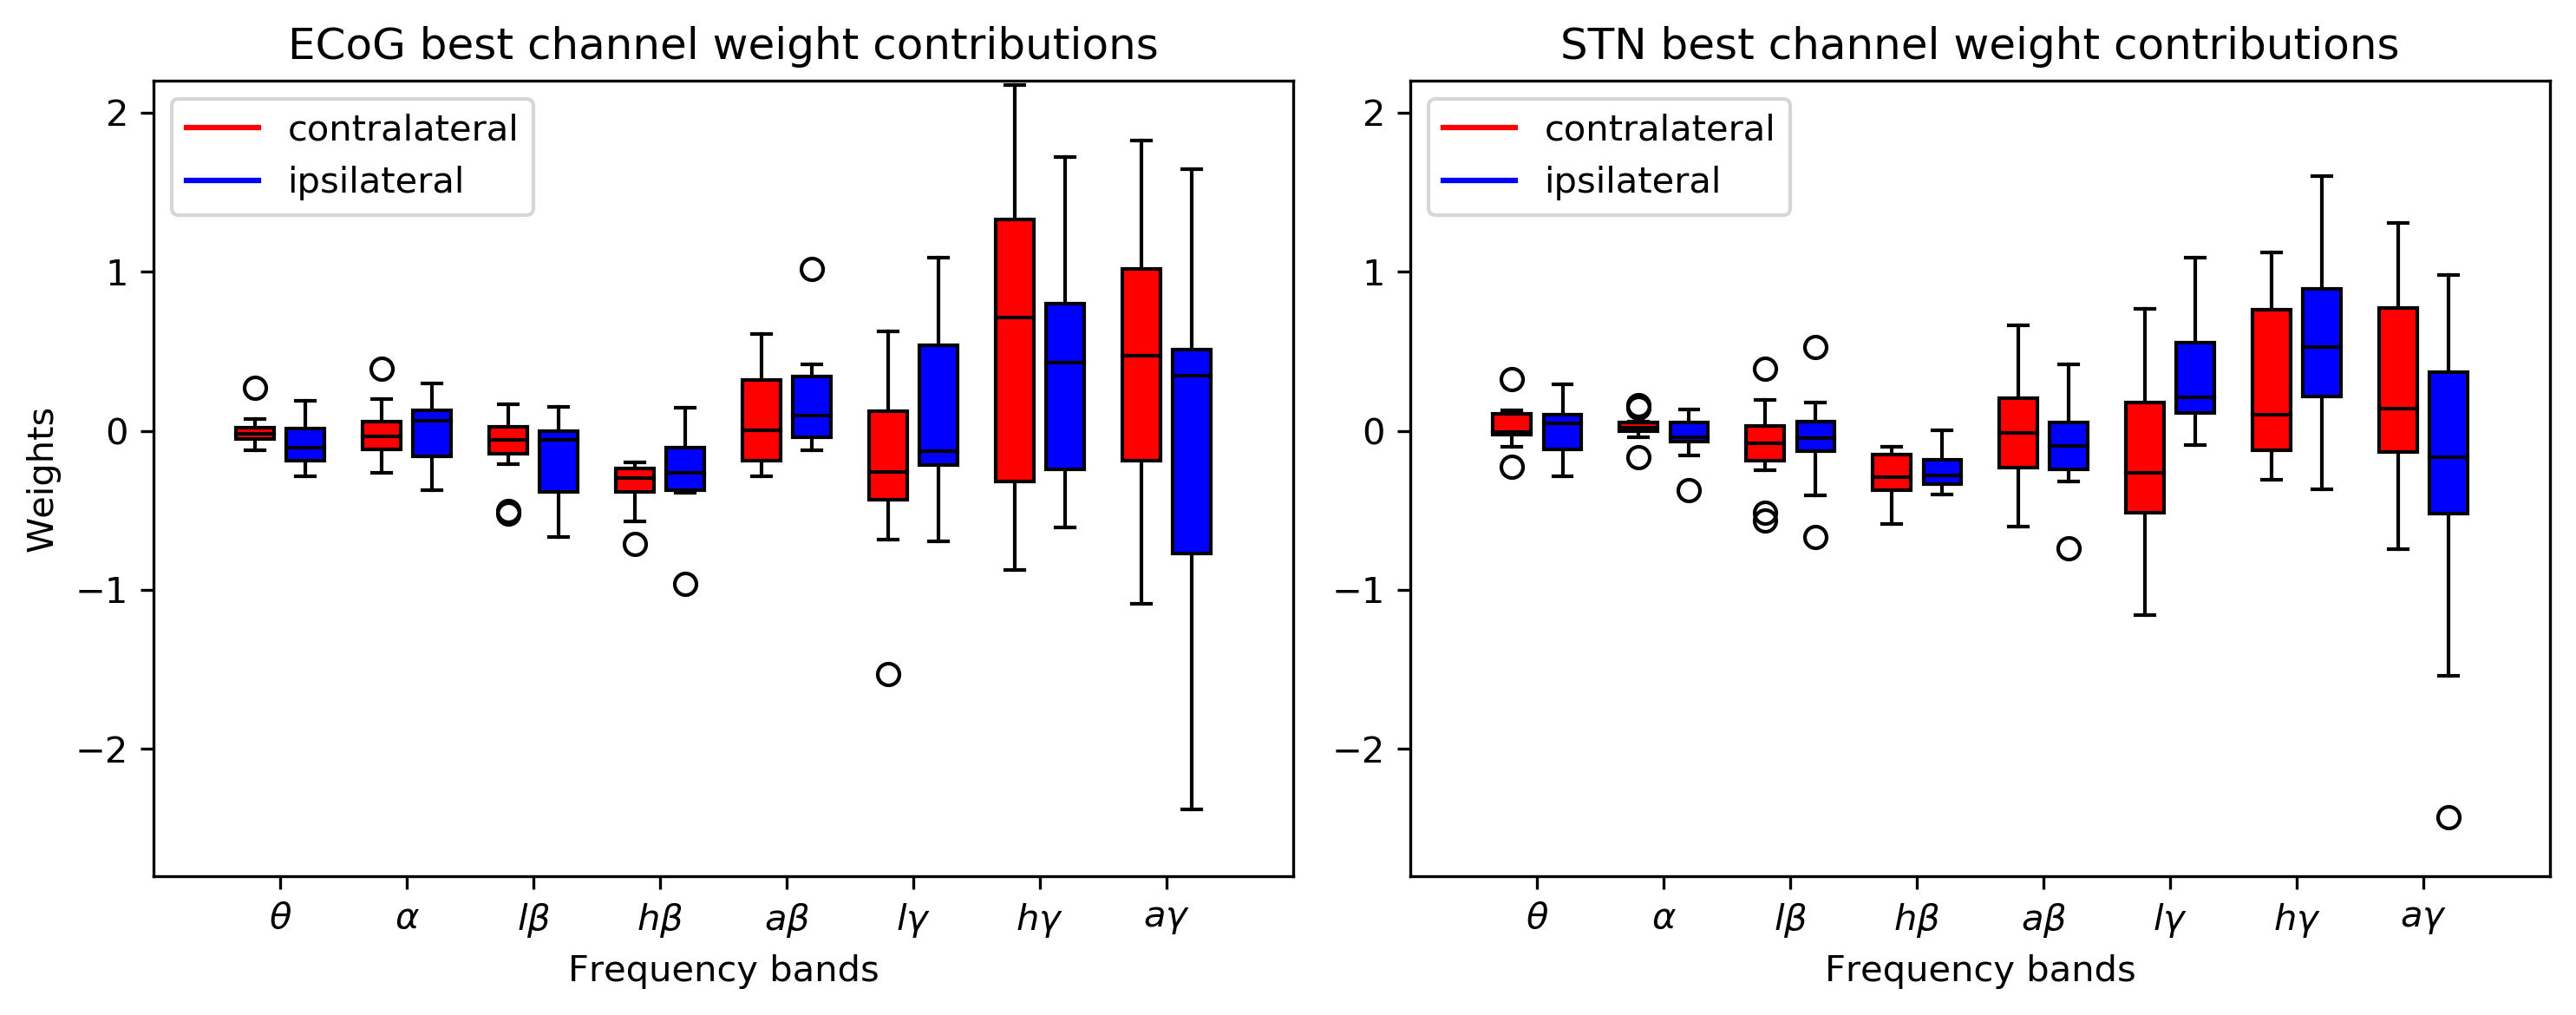

In [44]:
plt.figure(figsize=(10, 4), dpi=300)
plt.subplot(1,2,1)
my_boxplot_weights(weights_ecog_con,  weights_ecog_ips)
plt.legend()
plt.ylabel('Weights')
plt.ylim(-2.8,2.2)
plt.title('ECoG best channel weight contributions')
plt.xlabel('Frequency bands'); #plt.grid(True)


plt.subplot(1,2,2)
my_boxplot_weights(weights_stn_con,  weights_stn_ips)
plt.legend(loc='upper left')
plt.title('STN best channel weight contributions')
plt.ylim(-2.8,2.2)
plt.tight_layout()
plt.xlabel('Frequency bands'); #plt.grid(True)
plt.show()